In [1]:
# 05_sp500_cs_tree_robustness.ipynb
# Robustness of cross-sectional SP500 tree vs momentum across multiple test windows

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
from pathlib import Path


import optuna
from sklearn.ensemble import HistGradientBoostingRegressor

plt.style.use("seaborn-v0_8-darkgrid")

def sharpe_ratio_np(returns, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0 or np.isclose(r.std(), 0.0):
        return 0.0
    return np.sqrt(freq) * r.mean() / r.std()


C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)

from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [3]:
# --- Global transaction cost setting ---
# round-trip cost as a fraction of notional per 21-day "trade"
# 0.0005 = 5 bps, 0.001 = 10 bps, etc.
COST_BPS = 0.001  # tweak this to whatever you want to assume


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6530 entries, 2000-01-03 to 2025-12-17
Columns: 453 entries, NVDA to NWS
dtypes: float64(453)
memory usage: 22.6 MB
Price panel shape: (6530, 453)
Date range: 2000-01-03 00:00:00 -> 2025-12-17 00:00:00
Number of tickers: 453


c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2505045, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Unique tickers in signals: 451
X shape: (2505045, 11)
y shape: (2505045,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Num unique tickers: 451


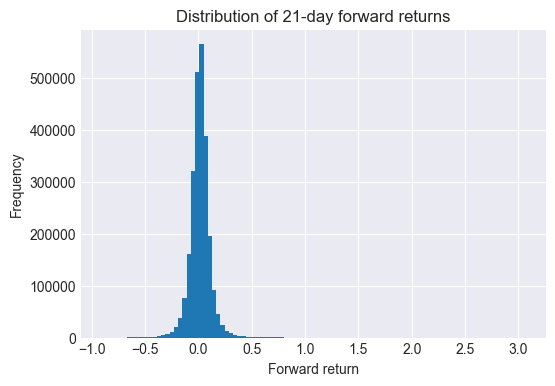

In [4]:
# Load SP500 panel as long as we can reasonably go
# (set force_download=True the first time if needed)
prices = load_sp500_adj_close(start="2000-01-01")

prices.info()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))

lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))

# Build big (X, y, dates, tickers) matrix
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity check on forward-return distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [5]:
def daily_momentum_cs(
    group: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    cost_bps: round-trip cost per 21-day position.
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return, frictionless)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return (classical cross-sectional momentum)
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()
    long_short_21 = long_ret_21 - short_ret_21

    # Apply transaction costs on 21-day horizon
    if cost_bps > 0.0:
        long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
        long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

    # convert to daily
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily    = to_daily(eqw_ret_21)
    long_ret_daily   = to_daily(long_ret_21)
    long_short_daily = to_daily(long_short_21)

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


def compute_cs_daily_returns(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    df: index (date, symbol), columns: y_true, y_pred (21d fwd returns + predictions)
    Returns three Series of *daily-equivalent* returns:
        eqw, long-only (top q), long-short (top q minus bottom q)

    cost_bps:
        round-trip transaction cost per 21-day holding period as fraction
        e.g. 0.0005 = 5 bps, 0.001 = 10 bps.
        Applied once for a long-only position and twice for a long-short position.
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Equal-weight all stocks -> benchmark (frictionless)
        eqw_ret_21 = group["y_true"].mean()

        # Sort by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]     # worst predicted
        top    = g_sorted.iloc[-k:]    # best predicted

        long_ret_21  = top["y_true"].mean()
        short_ret_21 = bottom["y_true"].mean()

        long_short_21 = long_ret_21 - short_ret_21

        # apply transaction costs
        if cost_bps > 0.0:
            long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [6]:
def compute_cs_daily_returns_gated(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    Like compute_cs_daily_returns, but:
    - uses model predictions to decide whether to trade at all,
    - only applies costs on days where we actually trade.

    df: index (date, symbol), columns: y_true, y_pred
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Benchmark: equal-weight all stocks (no costs)
        eqw_ret_21 = group["y_true"].mean()

        # Rank by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]
        top    = g_sorted.iloc[-k:]

        # --- True 21d returns (what actually happens) ---
        long_true_21  = top["y_true"].mean()
        short_true_21 = bottom["y_true"].mean()
        long_short_true_21 = long_true_21 - short_true_21

        # --- Predicted 21d returns (model view) ---
        long_pred_21  = top["y_pred"].mean()
        short_pred_21 = bottom["y_pred"].mean()
        long_short_pred_21 = long_pred_21 - short_pred_21

        # ---- Decision: do we trade? ----
        # Long-only: require predicted edge > cost
        trade_long = long_pred_21 > cost_bps

        # Long-short: require predicted spread > 2 * cost
        trade_ls   = long_short_pred_21 > 2.0 * cost_bps

        # Start from "no trade"
        long_ret_21      = 0.0
        long_short_21    = 0.0

        if trade_long:
            long_ret_21 = long_true_21

        if trade_ls:
            long_short_21 = long_short_true_21

        # ---- Apply costs only if we actually trade ----
        if cost_bps > 0.0 and trade_long:
            long_ret_21 = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0

        if cost_bps > 0.0 and trade_ls:
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        # Convert 21-day returns to daily-equivalent
        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [7]:
def run_cs_window(
    test_start: str,
    test_end: str,
    X: np.ndarray,
    y: np.ndarray,
    dates: pd.Series,
    tickers: np.ndarray,
    signals_df: pd.DataFrame,
    n_trials: int = 10,
    q_mom: float = 0.1,
    random_state: int = 42,
):
    """
    Run the full pipeline for a single test window:
    - Train/val on data *before* test_start
    - Tune tree + q on validation long-short Sharpe (net of costs)
    - Evaluate momentum and tree on [test_start, test_end]
    """
    test_start = pd.Timestamp(test_start)
    test_end   = pd.Timestamp(test_end)

    # Masks for this window
    test_mask = (dates >= test_start) & (dates <= test_end)
    hist_mask = dates < test_start

    if test_mask.sum() == 0 or hist_mask.sum() < 1000:
        print(f"Skipping window {test_start.date()}–{test_end.date()} (not enough data).")
        return None

    hist_dates = np.array(sorted(dates[hist_mask].unique()))
    # 70/30 split of *history* into train/val
    train_end_local = hist_dates[int(len(hist_dates) * 0.7)]

    train_mask = (dates <= train_end_local)
    val_mask   = (dates > train_end_local) & (dates < test_start)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    dates_val_local    = dates[val_mask]
    dates_test_local   = dates[test_mask]
    tickers_val_local  = tickers[val_mask]
    tickers_test_local = tickers[test_mask]

    print(
        f"Window {test_start.date()}–{test_end.date()} | "
        f"train={len(y_train)}, val={len(y_val)}, test={len(y_test)}"
    )

    # -------------------------
    # Optuna objective for this window
    # -------------------------
    def objective_tree_cs(trial):
        max_depth       = trial.suggest_int("max_depth", 2, 8)
        learning_rate   = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_iter        = trial.suggest_int("max_iter", 100, 500)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
        q               = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

        model = HistGradientBoostingRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            max_iter=max_iter,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)

        df_val = pd.DataFrame(
            {
                "date":   dates_val_local,
                "symbol": tickers_val_local,
                "y_true": y_val,
                "y_pred": y_pred_val,
            }
        ).set_index(["date", "symbol"]).sort_index()

        # Build portfolios on validation: long-short (NET of costs)
        _, _, long_short_val = compute_cs_daily_returns(
            df_val,
            q=q,
            horizon=lookahead,
            cost_bps=COST_BPS,
        )

        ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()

        if len(ret_series) < 20:
            return 0.0

        return -sharpe_ratio_np(ret_series.values)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_tree_cs, n_trials=n_trials)

    print("  Best params:", study.best_params)
    print("  Best val -Sharpe:", study.best_value)

    best_params = study.best_params.copy()
    q_best = best_params.pop("q")

    tree_best = HistGradientBoostingRegressor(
        **best_params,
        random_state=random_state,
    )

    # Train on all history (train+val) before test_start
    hist_mask_full = dates < test_start
    X_hist, y_hist = X[hist_mask_full], y[hist_mask_full]
    tree_best.fit(X_hist, y_hist)

    # -------------------------
    # 1) Momentum baseline on this test window (NET)
    # -------------------------
    idx_dates = signals_df.index.get_level_values("date")
    signals_test = signals_df.loc[
        (idx_dates >= test_start) & (idx_dates <= test_end)
    ].copy()

    daily_mom = signals_test.groupby("date").apply(
        daily_momentum_cs,
        q=q_mom,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    eqw_returns   = daily_mom["eqw"].astype(float)
    momL_returns  = daily_mom["long"].astype(float)
    momLS_returns = daily_mom["long_short"].astype(float)

    # -------------------------
    # 2) Tree strategy on this test window (NET)
    # -------------------------
    y_pred_test = tree_best.predict(X_test)

    df_test = pd.DataFrame(
        {
            "date":   dates_test_local,
            "symbol": tickers_test_local,
            "y_true": y_test,
            "y_pred": y_pred_test,
        }
    ).set_index(["date", "symbol"]).sort_index()

    _, treeL_returns, treeLS_returns = compute_cs_daily_returns(
        df_test, q=q_best, horizon=lookahead, cost_bps=COST_BPS
    )

    # -------------------------
    # 3) Equity curves + metrics
    # -------------------------
    eqw_eq     = equity_curve_from_returns(eqw_returns)
    momL_eq    = equity_curve_from_returns(momL_returns)
    momLS_eq   = equity_curve_from_returns(momLS_returns)
    treeL_eq   = equity_curve_from_returns(treeL_returns)
    treeLS_eq  = equity_curve_from_returns(treeLS_returns)

    metrics = {
        "test_start": test_start.date(),
        "test_end":   test_end.date(),

        "momL_cagr":    cagr(momL_eq),
        "momL_sharpe":  sharpe_ratio(momL_returns),
        "momL_max_dd":  max_drawdown(momL_eq),

        "treeL_cagr":   cagr(treeL_eq),
        "treeL_sharpe": sharpe_ratio(treeL_returns),
        "treeL_max_dd": max_drawdown(treeL_eq),

        "momLS_cagr":   cagr(momLS_eq),
        "momLS_sharpe": sharpe_ratio(momLS_returns),
        "momLS_max_dd": max_drawdown(momLS_eq),

        "treeLS_cagr":   cagr(treeLS_eq),
        "treeLS_sharpe": sharpe_ratio(treeLS_returns),
        "treeLS_max_dd": max_drawdown(treeLS_eq),
    }

    # quick plot for this window
    plt.figure(figsize=(9, 4))
    momL_eq.plot(label="Momentum long-only (net)")
    treeL_eq.plot(label="Tree long-only (Optuna, net)")
    plt.legend()
    plt.title(f"Long-only (net of costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    plt.figure(figsize=(9, 4))
    momLS_eq.plot(label="Momentum long-short (net)")
    treeLS_eq.plot(label="Tree long-short (Optuna, net)")
    plt.legend()
    plt.title(f"Long-short (net of costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    return metrics


[I 2025-12-23 10:28:00,203] A new study created in memory with name: no-name-8bc47017-556c-4770-9676-6b7c81a45233


Window 2005-01-01–2009-12-31 | train=242459, val=107861, test=459337


[I 2025-12-23 10:28:13,225] Trial 0 finished with value: -2.121934791270499 and parameters: {'max_depth': 2, 'learning_rate': 0.011114485316300902, 'max_iter': 283, 'min_samples_leaf': 102, 'q': 0.06375255314395949}. Best is trial 0 with value: -2.121934791270499.
[I 2025-12-23 10:28:23,289] Trial 1 finished with value: -4.412394001112305 and parameters: {'max_depth': 4, 'learning_rate': 0.1618417080897173, 'max_iter': 376, 'min_samples_leaf': 106, 'q': 0.07079978158510537}. Best is trial 1 with value: -4.412394001112305.
[I 2025-12-23 10:28:49,248] Trial 2 finished with value: -2.416874387047275 and parameters: {'max_depth': 3, 'learning_rate': 0.027273885196212218, 'max_iter': 284, 'min_samples_leaf': 96, 'q': 0.11347024560134207}. Best is trial 1 with value: -4.412394001112305.
[I 2025-12-23 10:29:00,595] Trial 3 finished with value: -1.9524956309252457 and parameters: {'max_depth': 3, 'learning_rate': 0.013559745721738573, 'max_iter': 485, 'min_samples_leaf': 105, 'q': 0.0822015906

  Best params: {'max_depth': 4, 'learning_rate': 0.1618417080897173, 'max_iter': 376, 'min_samples_leaf': 106, 'q': 0.07079978158510537}
  Best val -Sharpe: -4.412394001112305


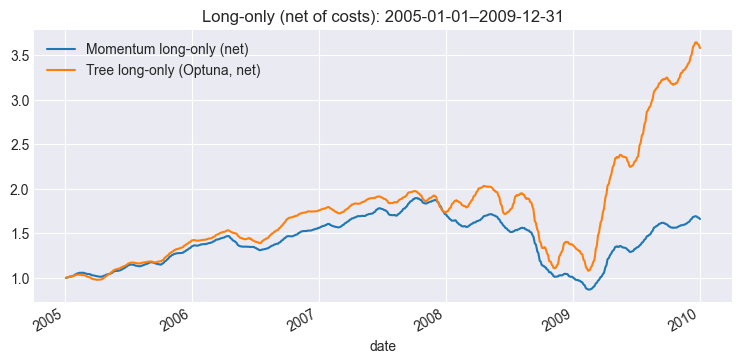

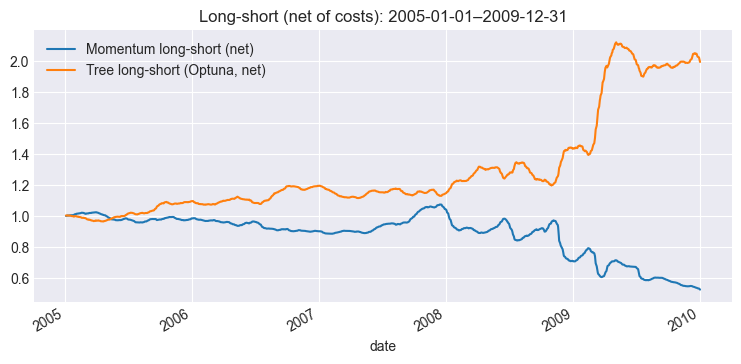

[I 2025-12-23 10:30:18,297] A new study created in memory with name: no-name-beb6d01c-0fa6-4959-8567-14c3f819273b


Window 2010-01-01–2014-12-31 | train=549813, val=259844, test=501850


[I 2025-12-23 10:30:56,586] Trial 0 finished with value: -3.837641250155029 and parameters: {'max_depth': 5, 'learning_rate': 0.18253304123971606, 'max_iter': 429, 'min_samples_leaf': 85, 'q': 0.18397643643928435}. Best is trial 0 with value: -3.837641250155029.
[I 2025-12-23 10:31:25,840] Trial 1 finished with value: -3.709099679237557 and parameters: {'max_depth': 8, 'learning_rate': 0.12596934395324066, 'max_iter': 291, 'min_samples_leaf': 33, 'q': 0.15759384131068216}. Best is trial 0 with value: -3.837641250155029.
[I 2025-12-23 10:31:44,536] Trial 2 finished with value: -4.121429848153845 and parameters: {'max_depth': 3, 'learning_rate': 0.19753653016181633, 'max_iter': 478, 'min_samples_leaf': 73, 'q': 0.17268512837324346}. Best is trial 2 with value: -4.121429848153845.
[I 2025-12-23 10:31:51,256] Trial 3 finished with value: -3.4445725665334463 and parameters: {'max_depth': 2, 'learning_rate': 0.16492974939731886, 'max_iter': 107, 'min_samples_leaf': 173, 'q': 0.18485264653008

  Best params: {'max_depth': 6, 'learning_rate': 0.1424489455313992, 'max_iter': 500, 'min_samples_leaf': 168, 'q': 0.10815067350863151}
  Best val -Sharpe: -4.792170122721333


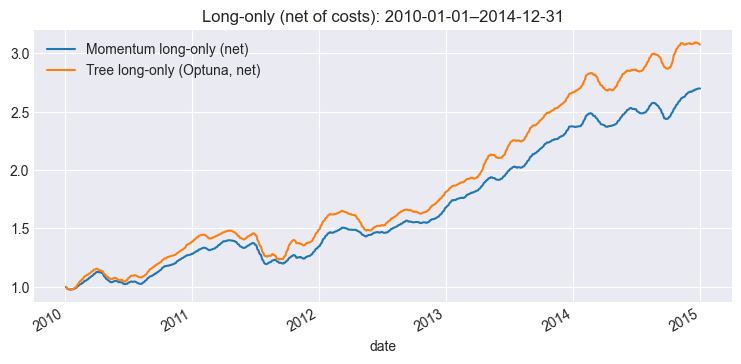

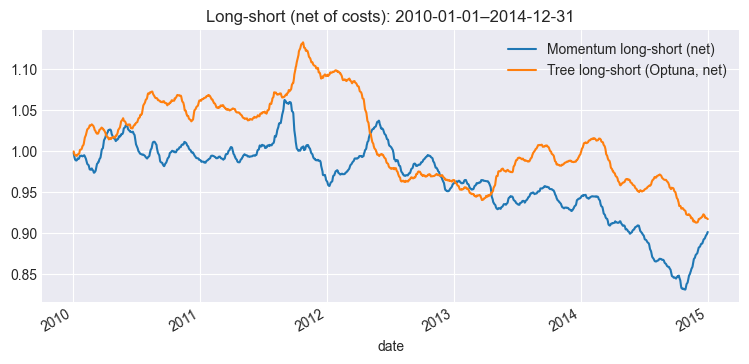

[I 2025-12-23 10:34:59,102] A new study created in memory with name: no-name-b3ede291-f69b-40bc-9072-ae320878943c


Window 2015-01-01–2019-12-31 | train=880883, val=430624, test=536253


[I 2025-12-23 10:35:36,181] Trial 0 finished with value: -0.14875246364460204 and parameters: {'max_depth': 3, 'learning_rate': 0.048831662596680515, 'max_iter': 350, 'min_samples_leaf': 192, 'q': 0.17377520200704089}. Best is trial 0 with value: -0.14875246364460204.
[I 2025-12-23 10:36:43,100] Trial 1 finished with value: 0.4152595679260681 and parameters: {'max_depth': 7, 'learning_rate': 0.027115018336507226, 'max_iter': 480, 'min_samples_leaf': 74, 'q': 0.146425257294293}. Best is trial 0 with value: -0.14875246364460204.
[I 2025-12-23 10:37:02,677] Trial 2 finished with value: -0.977785798521307 and parameters: {'max_depth': 2, 'learning_rate': 0.033321741721826885, 'max_iter': 265, 'min_samples_leaf': 68, 'q': 0.06058740295704808}. Best is trial 2 with value: -0.977785798521307.
[I 2025-12-23 10:37:37,250] Trial 3 finished with value: 0.7871111494951257 and parameters: {'max_depth': 8, 'learning_rate': 0.06575270827772656, 'max_iter': 320, 'min_samples_leaf': 124, 'q': 0.1482773

  Best params: {'max_depth': 2, 'learning_rate': 0.033321741721826885, 'max_iter': 265, 'min_samples_leaf': 68, 'q': 0.06058740295704808}
  Best val -Sharpe: -0.977785798521307


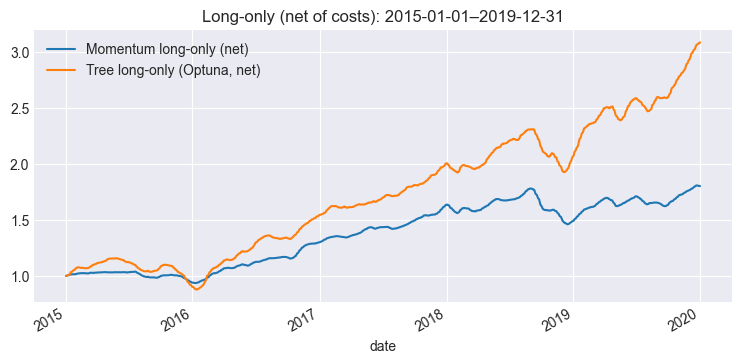

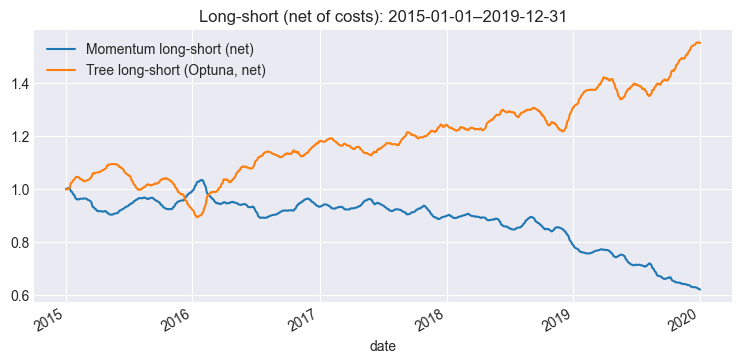

[I 2025-12-23 10:41:23,105] A new study created in memory with name: no-name-ea9c8722-0975-4074-bab0-0f7ad6d38e97


Window 2020-01-01–2024-12-31 | train=1232188, val=615572, test=558111


[I 2025-12-23 10:42:09,689] Trial 0 finished with value: -2.653535834524901 and parameters: {'max_depth': 5, 'learning_rate': 0.01258629520053661, 'max_iter': 314, 'min_samples_leaf': 152, 'q': 0.12228898720316121}. Best is trial 0 with value: -2.653535834524901.
[I 2025-12-23 10:42:46,878] Trial 1 finished with value: -1.7937313537685446 and parameters: {'max_depth': 6, 'learning_rate': 0.11241964178427051, 'max_iter': 243, 'min_samples_leaf': 150, 'q': 0.15785665824929113}. Best is trial 0 with value: -2.653535834524901.
[I 2025-12-23 10:43:32,029] Trial 2 finished with value: -2.445650634996431 and parameters: {'max_depth': 3, 'learning_rate': 0.10945111433934822, 'max_iter': 411, 'min_samples_leaf': 155, 'q': 0.08116035729396572}. Best is trial 0 with value: -2.653535834524901.
[I 2025-12-23 10:44:04,364] Trial 3 finished with value: -2.48775071216103 and parameters: {'max_depth': 3, 'learning_rate': 0.028294670955474346, 'max_iter': 304, 'min_samples_leaf': 63, 'q': 0.170264389516

  Best params: {'max_depth': 5, 'learning_rate': 0.01258629520053661, 'max_iter': 314, 'min_samples_leaf': 152, 'q': 0.12228898720316121}
  Best val -Sharpe: -2.653535834524901


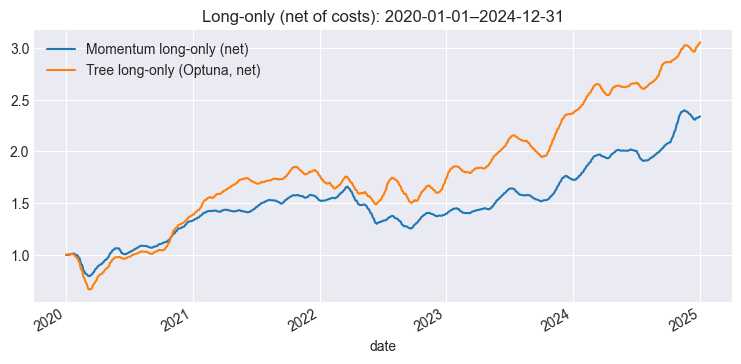

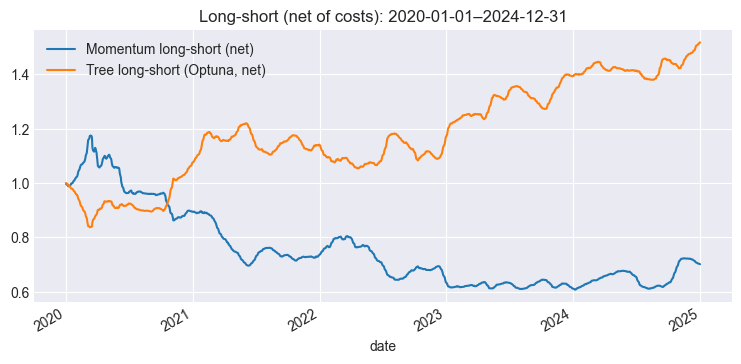

,test_start,test_end,momL_cagr,momL_sharpe,momL_max_dd,treeL_cagr,treeL_sharpe,treeL_max_dd,momLS_cagr,momLS_sharpe,momLS_max_dd,treeLS_cagr,treeLS_sharpe,treeLS_max_dd
0,2005-01-01,2009-12-31,0.106992,1.861044,-0.541993,0.290393,3.390085,-0.469118,-0.121386,-1.875314,-0.511963,0.147621,3.224798,-0.111597
1,2010-01-01,2014-12-31,0.220422,6.471051,-0.146564,0.252597,6.301038,-0.167655,-0.020076,-0.933459,-0.217081,-0.017060,-0.925815,-0.193598
2,2015-01-01,2019-12-31,0.125113,4.379338,-0.179420,0.253193,6.025602,-0.241266,-0.091091,-3.260790,-0.399704,0.092130,2.913655,-0.183694
3,2020-01-01,2024-12-31,0.185737,3.690401,-0.243806,0.250462,3.898378,-0.341532,-0.068187,-1.396745,-0.482553,0.087142,2.252679,-0.163079


In [8]:
test_windows = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2014-12-31"),
    ("2015-01-01", "2019-12-31"),
    ("2020-01-01", "2024-12-31"),
]

results = []
for start, end in test_windows:
    print("=" * 80)
    m = run_cs_window(
        start,
        end,
        X=X,
        y=y,
        dates=dates,
        tickers=tickers,
        signals_df=signals_df,
        n_trials=10,
        q_mom=0.1,
    )
    if m is not None:
        results.append(m)

results_df = pd.DataFrame(results)
results_df


In [9]:
summary_cols = [
    "test_start", "test_end",
    "momL_sharpe", "treeL_sharpe",
    "momLS_sharpe", "treeLS_sharpe",
]

summary = results_df[summary_cols].copy()
summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe
0,2005-01-01,2009-12-31,1.861044,3.390085,-1.875314,3.224798
1,2010-01-01,2014-12-31,6.471051,6.301038,-0.933459,-0.925815
2,2015-01-01,2019-12-31,4.379338,6.025602,-3.260790,2.913655
3,2020-01-01,2024-12-31,3.690401,3.898378,-1.396745,2.252679


In [10]:
summary["treeL_minus_momL"]   = summary["treeL_sharpe"]  - summary["momL_sharpe"]
summary["treeLS_minus_momLS"] = summary["treeLS_sharpe"] - summary["momLS_sharpe"]

summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe,treeL_minus_momL,treeLS_minus_momLS
0,2005-01-01,2009-12-31,1.861044,3.390085,-1.875314,3.224798,1.529041,5.100112
1,2010-01-01,2014-12-31,6.471051,6.301038,-0.933459,-0.925815,-0.170013,0.007644
2,2015-01-01,2019-12-31,4.379338,6.025602,-3.260790,2.913655,1.646263,6.174444
3,2020-01-01,2024-12-31,3.690401,3.898378,-1.396745,2.252679,0.207976,3.649424


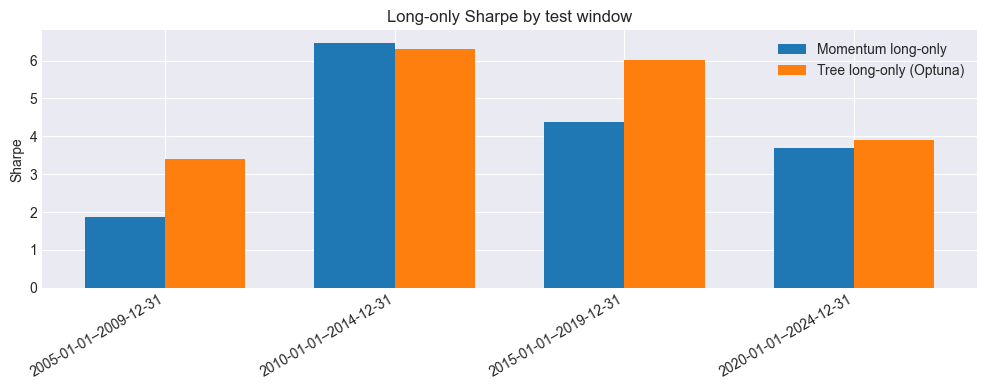

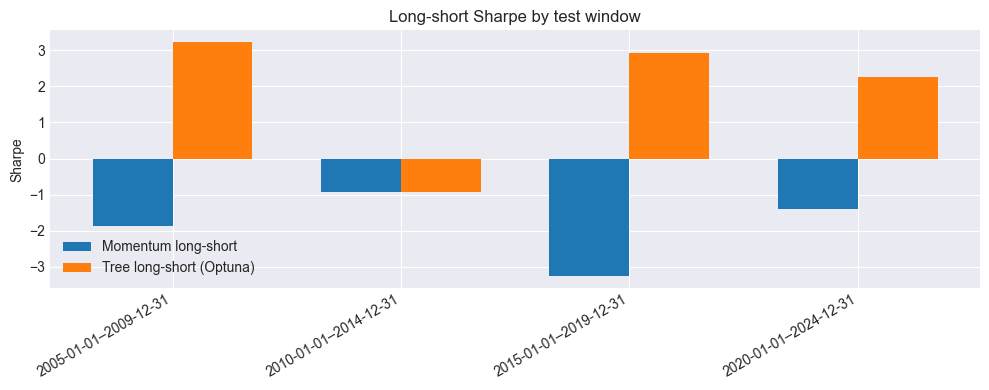

In [11]:
# Nice labels for windows
window_labels = (
    results_df["test_start"].astype(str)
    + "–"
    + results_df["test_end"].astype(str)
)
x = np.arange(len(results_df))
width = 0.35

# --- Long-only Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momL_sharpe"], width, label="Momentum long-only")
plt.bar(x + width/2, results_df["treeL_sharpe"], width, label="Tree long-only (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-only Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()

# --- Long-short Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momLS_sharpe"], width, label="Momentum long-short")
plt.bar(x + width/2, results_df["treeLS_sharpe"], width, label="Tree long-short (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-short Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()


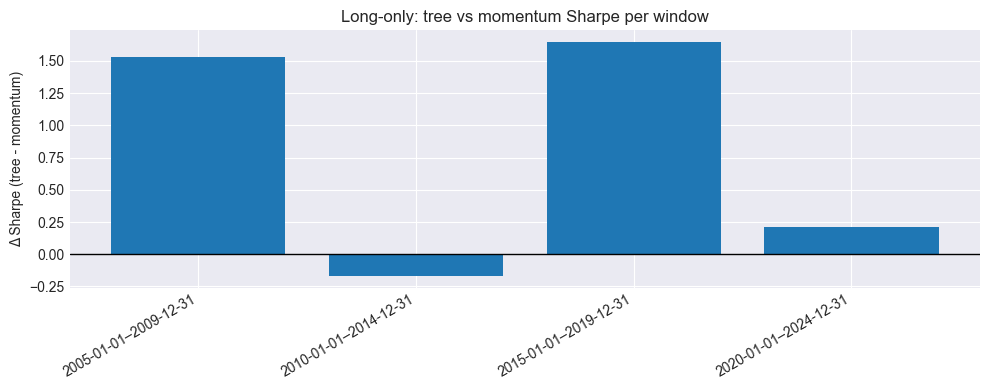

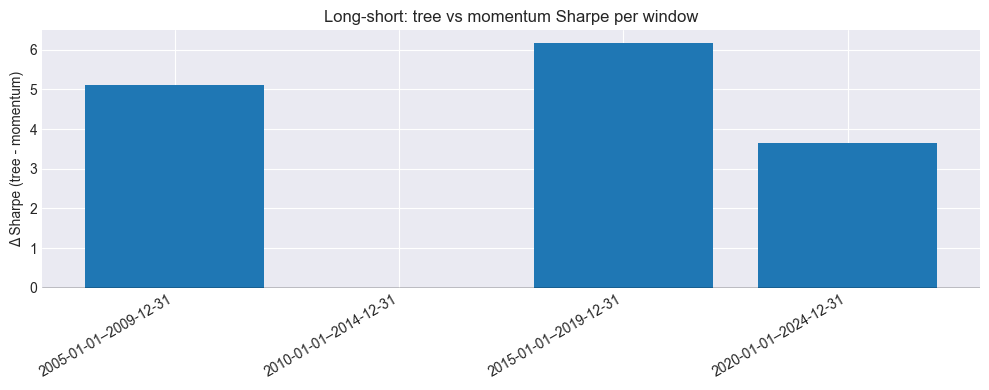

In [12]:
# Add differences if not already there
results_df["treeL_minus_momL"]   = results_df["treeL_sharpe"]  - results_df["momL_sharpe"]
results_df["treeLS_minus_momLS"] = results_df["treeLS_sharpe"] - results_df["momLS_sharpe"]

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeL_minus_momL"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-only: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeLS_minus_momLS"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-short: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()


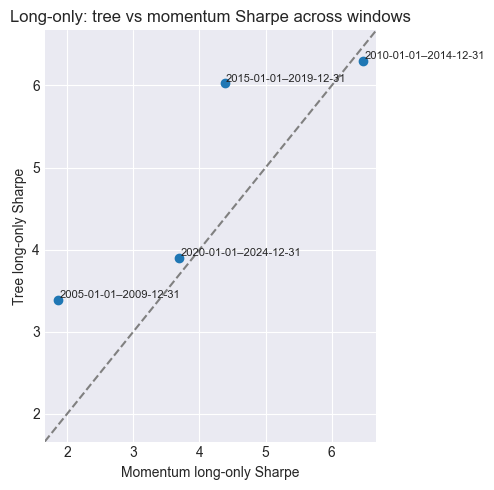

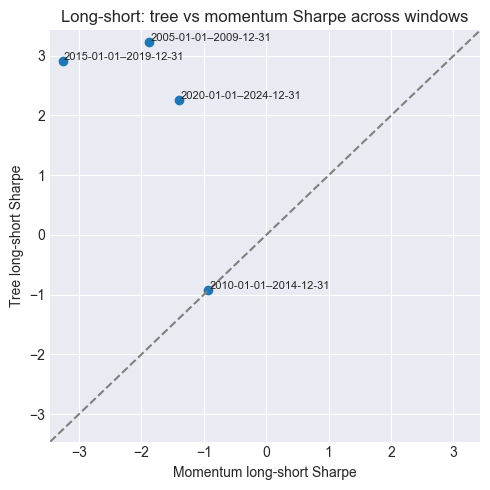

In [13]:
# Long-only scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momL_sharpe"], results_df["treeL_sharpe"])
lims = [
    min(results_df["momL_sharpe"].min(), results_df["treeL_sharpe"].min()) - 0.2,
    max(results_df["momL_sharpe"].max(), results_df["treeL_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")  # y = x line
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momL_sharpe"].iloc[i] + 0.02,
        results_df["treeL_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-only Sharpe")
plt.ylabel("Tree long-only Sharpe")
plt.title("Long-only: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()

# Long-short scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momLS_sharpe"], results_df["treeLS_sharpe"])
lims = [
    min(results_df["momLS_sharpe"].min(), results_df["treeLS_sharpe"].min()) - 0.2,
    max(results_df["momLS_sharpe"].max(), results_df["treeLS_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momLS_sharpe"].iloc[i] + 0.02,
        results_df["treeLS_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-short Sharpe")
plt.ylabel("Tree long-short Sharpe")
plt.title("Long-short: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()


In [14]:
# === PAPER TRADING MODE, FOR RESEARCH PURPOSE ONLY: cross-sectional SP500 picks for "tomorrow" ===

from IPython.display import display

TOP_N_LONG = 20   # how many longs to show
TOP_N_SHORT = 20  # how many shorts to show

# 1) Choose as-of date: last date where we have signals/targets
as_of_date = dates.max()
print(f"As-of date for paper trading: {as_of_date.date()}")

# ----- build train / val sets using only history before as_of_date -----
hist_mask = dates < as_of_date
if hist_mask.sum() < 1000:
    raise ValueError("Not enough history before as_of_date for a meaningful model.")

hist_dates = np.array(sorted(dates[hist_mask].unique()))
train_end_live = hist_dates[int(len(hist_dates) * 0.7)]

train_mask_live = (dates <= train_end_live)
val_mask_live   = (dates > train_end_live) & (dates < as_of_date)

X_train_live, y_train_live = X[train_mask_live], y[train_mask_live]
X_val_live,   y_val_live   = X[val_mask_live],   y[val_mask_live]

dates_val_live   = dates[val_mask_live]
tickers_val_live = tickers[val_mask_live]

print(
    f"Live setup | train={len(y_train_live)} samples "
    f"val={len(y_val_live)} samples (all < {as_of_date.date()})"
)

# 2) Optuna objective: tune tree hyperparams + q on long-short Sharpe (net of cost)
def objective_tree_live(trial):
    max_depth       = trial.suggest_int("max_depth", 2, 8)
    learning_rate   = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_iter        = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
    q               = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

    model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train_live, y_train_live)

    y_pred_val = model.predict(X_val_live)

    df_val_live = (
        pd.DataFrame(
            {
                "date":   dates_val_live,
                "symbol": tickers_val_live,
                "y_true": y_val_live,
                "y_pred": y_pred_val,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    # build long/short portfolios on validation (net of transaction costs)
    _, long_val, long_short_val = compute_cs_daily_returns(
        df_val_live,
        q=q,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()
    if len(ret_series) < 20:
        return 0.0  # treat as bad if too little data

    return -sharpe_ratio_np(ret_series.values)  # Optuna MINIMIZES

study_live = optuna.create_study(direction="minimize")
study_live.optimize(objective_tree_live, n_trials=20)

print("Best live params:", study_live.best_params)
print("Best live val -Sharpe:", study_live.best_value)

best_live = study_live.best_params.copy()
q_live = best_live.pop("q")

# 3) Train final tree on ALL history before as_of_date
tree_live = HistGradientBoostingRegressor(
    **best_live,
    random_state=42,
)

X_hist_live = X[hist_mask]
y_hist_live = y[hist_mask]
tree_live.fit(X_hist_live, y_hist_live)

# 4) Predictions for the as-of date (our "today")
live_mask = dates == as_of_date
X_live = X[live_mask]
tickers_live = tickers[live_mask]

y_pred_live = tree_live.predict(X_live)

panel_live = pd.DataFrame(
    {
        "ticker": tickers_live,
        "pred_fwd_21": y_pred_live,   # model prediction: 21d total return (gross)
    }
).set_index("ticker")

# approximate net-of-fee 21d return for a long position
panel_live["pred_fwd_21_net_long"] = (1.0 + panel_live["pred_fwd_21"]) * (1.0 - COST_BPS) - 1.0
panel_live["pred_daily_net_long"] = (1.0 + panel_live["pred_fwd_21_net_long"]) ** (1.0 / lookahead) - 1.0

# cross-sectional average daily net return (like EW benchmark)
mean_daily_net = panel_live["pred_daily_net_long"].mean()
panel_live["edge_vs_eqw_daily"] = panel_live["pred_daily_net_long"] - mean_daily_net

# 5) Sort and show top/bottom N
panel_sorted = panel_live.sort_values("pred_fwd_21_net_long", ascending=False)

top_long  = panel_sorted.head(TOP_N_LONG).copy()
bottom_short = panel_sorted.tail(TOP_N_SHORT).copy()

print("\n=== Paper-trade recommendation ===")
print(f"As-of date: {as_of_date.date()}  |  lookahead: {lookahead} days")
print(
    f"Tuned q_live = {q_live:.3f}  "
    f"(strategy would typically long/short ~{int(q_live * len(panel_sorted))} names per side)"
)
print(f"Assumed round-trip cost: {COST_BPS * 1e4:.1f} bps per 21d holding period")

print("\nTop tickers to LONG (preview, net of costs):")
display(
    top_long[
        ["pred_fwd_21", "pred_fwd_21_net_long", "pred_daily_net_long", "edge_vs_eqw_daily"]
    ].sort_values("pred_fwd_21_net_long", ascending=False)
)

print("\nBottom tickers to SHORT (preview, net of costs):")
# for shorts, a strongly negative predicted return is good
display(
    bottom_short[
        ["pred_fwd_21", "pred_fwd_21_net_long", "pred_daily_net_long", "edge_vs_eqw_daily"]
    ].sort_values("pred_fwd_21_net_long")  # most negative first
)


As-of date for paper trading: 2025-11-17


[I 2025-12-23 10:50:32,689] A new study created in memory with name: no-name-8c45ce8d-5e82-4cf9-b2d4-a8e1c7845b62


Live setup | train=1668712 samples val=835884 samples (all < 2025-11-17)


[I 2025-12-23 10:51:34,607] Trial 0 finished with value: -2.291987445860336 and parameters: {'max_depth': 2, 'learning_rate': 0.013302925619474423, 'max_iter': 414, 'min_samples_leaf': 81, 'q': 0.27660671671844517}. Best is trial 0 with value: -2.291987445860336.
[I 2025-12-23 10:52:22,539] Trial 1 finished with value: -1.6022987944641471 and parameters: {'max_depth': 2, 'learning_rate': 0.12002284644212968, 'max_iter': 269, 'min_samples_leaf': 38, 'q': 0.22302604848041319}. Best is trial 0 with value: -2.291987445860336.
[I 2025-12-23 10:53:45,741] Trial 2 finished with value: -1.374778308591365 and parameters: {'max_depth': 4, 'learning_rate': 0.051928757200076295, 'max_iter': 480, 'min_samples_leaf': 105, 'q': 0.18836775008492368}. Best is trial 0 with value: -2.291987445860336.
[I 2025-12-23 10:54:40,433] Trial 3 finished with value: -1.498549784950094 and parameters: {'max_depth': 5, 'learning_rate': 0.03165595313920556, 'max_iter': 284, 'min_samples_leaf': 200, 'q': 0.19042346038

Best live params: {'max_depth': 2, 'learning_rate': 0.010175723050940073, 'max_iter': 426, 'min_samples_leaf': 80, 'q': 0.05394544906674251}
Best live val -Sharpe: -3.068325648315957

=== Paper-trade recommendation ===
As-of date: 2025-11-17  |  lookahead: 21 days
Tuned q_live = 0.054  (strategy would typically long/short ~24 names per side)
Assumed round-trip cost: 10.0 bps per 21d holding period

Top tickers to LONG (preview, net of costs):


,pred_fwd_21,pred_fwd_21_net_long,pred_daily_net_long,edge_vs_eqw_daily
ticker,,,,
MOH,0.037916,0.036878,0.001726,0.001091
HOOD,0.035334,0.034299,0.001607,0.000972
STX,0.035073,0.034038,0.001595,0.000960
WDC,0.034398,0.033364,0.001564,0.000929
MU,0.034383,0.033349,0.001563,0.000928
TER,0.032844,0.031812,0.001492,0.000857
WBD,0.032446,0.031414,0.001474,0.000839
PLTR,0.031000,0.029969,0.001407,0.000772
APP,0.031000,0.029969,0.001407,0.000772



Bottom tickers to SHORT (preview, net of costs):


,pred_fwd_21,pred_fwd_21_net_long,pred_daily_net_long,edge_vs_eqw_daily
ticker,,,,
VRTX,0.008383,0.007374,0.000350,-0.000285
UPS,0.008421,0.007412,0.000352,-0.000283
WELL,0.008484,0.007476,0.000355,-0.000280
VTR,0.008484,0.007476,0.000355,-0.000280
NEE,0.008484,0.007476,0.000355,-0.000280
HCA,0.008484,0.007476,0.000355,-0.000280
CB,0.008484,0.007476,0.000355,-0.000280
CBOE,0.008484,0.007476,0.000355,-0.000280
FDX,0.008484,0.007476,0.000355,-0.000280


In [15]:
# =============================================================================
# Final live model: global tuning on full history, then train once & save
# =============================================================================

# 1) Global train/validation split over all dates (for hyperparameter tuning)
all_dates = np.array(sorted(dates.unique()))
split_idx = int(len(all_dates) * 0.7)
train_end_global = all_dates[split_idx]

mask_train_global = dates <= train_end_global
mask_val_global   = dates > train_end_global

X_train_g, y_train_g = X[mask_train_global], y[mask_train_global]
X_val_g,   y_val_g   = X[mask_val_global],   y[mask_val_global]

dates_val_g   = dates[mask_val_global]
tickers_val_g = tickers[mask_val_global]

print("Global tuning:")
print("  Train dates:", dates[mask_train_global].min(), "->", dates[mask_train_global].max())
print("  Val   dates:", dates_val_g.min(), "->", dates_val_g.max())
print("  Train samples:", len(y_train_g), " Val samples:", len(y_val_g))


def objective_tree_global(trial):
    # --- Tree hyperparameters ---
    max_depth = trial.suggest_int("max_depth", 2, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)
    # long/short bucket size
    q = trial.suggest_float("q", 0.05, 0.3)

    model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train_g, y_train_g)

    # Predictions on validation
    y_pred_val = model.predict(X_val_g)

    df_val_g = (
        pd.DataFrame(
            {
                "date":   dates_val_g,
                "symbol": tickers_val_g,
                "y_true": y_val_g,
                "y_pred": y_pred_val,
            }
        )
        .set_index(["date", "symbol"])
        .sort_index()
    )

    # Build long-only & long-short portfolios on validation, NET of costs
    _, long_val_g, long_short_val_g = compute_cs_daily_returns(
        df_val_g,
        q=q,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    # We optimize **long-only** net Sharpe (you can switch to long_short_val_g if you want)
    ret_series = long_val_g.replace([np.inf, -np.inf], np.nan).dropna()
    if len(ret_series) < 20:
        return 0.0

    return -sharpe_ratio_np(ret_series.values)


study_global = optuna.create_study(direction="minimize")
study_global.optimize(objective_tree_global, n_trials=20)

print("Global best params:", study_global.best_params)
print("Global best -Sharpe (long-only, net):", study_global.best_value)

best_params_live = study_global.best_params.copy()
q_live = best_params_live.pop("q")


# 2) Train final model on ALL labeled history (X, y)
tree_cs_final = HistGradientBoostingRegressor(
    **best_params_live,
    random_state=42,
)
tree_cs_final.fit(X, y)

print("Final model trained on:", dates.min(), "->", dates.max())
print("Final model train R^2:", tree_cs_final.score(X, y))


# 3) Save bundle to disk for inference
models_dir = Path(PROJECT_ROOT) / "models"
models_dir.mkdir(exist_ok=True)

bundle = {
    "model": tree_cs_final,
    "q_live": q_live,
    "lookahead": lookahead,
    "cost_bps": COST_BPS,
    "features": CROSS_FEATURES,
    "train_start": str(dates.min().date()),
    "train_end":   str(dates.max().date()),
    "optuna_best_params": study_global.best_params,
    "optuna_best_value":  float(study_global.best_value),
}

out_path = models_dir / "sp500_tree_cs_21d_live.pkl"
joblib.dump(bundle, out_path)

print("Saved live model bundle to:", out_path)
print("q_live (fraction of names long/short):", q_live)


[I 2025-12-23 11:11:32,827] A new study created in memory with name: no-name-51987a97-6de2-4165-a8b4-7beab0579ec3


Global tuning:
  Train dates: 2000-10-16 00:00:00 -> 2018-05-09 00:00:00
  Val   dates: 2018-05-10 00:00:00 -> 2025-11-17 00:00:00
  Train samples: 1669142  Val samples: 835903


[I 2025-12-23 11:12:09,281] Trial 0 finished with value: -3.9864110590519855 and parameters: {'max_depth': 2, 'learning_rate': 0.012661942301356675, 'max_iter': 263, 'min_samples_leaf': 23, 'q': 0.10516717288362133}. Best is trial 0 with value: -3.9864110590519855.
[I 2025-12-23 11:12:55,241] Trial 1 finished with value: -4.057180933969437 and parameters: {'max_depth': 2, 'learning_rate': 0.03300306006760282, 'max_iter': 334, 'min_samples_leaf': 95, 'q': 0.10395590160361522}. Best is trial 1 with value: -4.057180933969437.
[I 2025-12-23 11:14:11,780] Trial 2 finished with value: -4.1518233783846945 and parameters: {'max_depth': 4, 'learning_rate': 0.09566121381168056, 'max_iter': 442, 'min_samples_leaf': 30, 'q': 0.09052027806986217}. Best is trial 2 with value: -4.1518233783846945.
[I 2025-12-23 11:14:42,830] Trial 3 finished with value: -3.848190780896512 and parameters: {'max_depth': 8, 'learning_rate': 0.15427837042933354, 'max_iter': 131, 'min_samples_leaf': 155, 'q': 0.1574852472

Global best params: {'max_depth': 4, 'learning_rate': 0.09833841635959865, 'max_iter': 162, 'min_samples_leaf': 88, 'q': 0.05220459968472445}
Global best -Sharpe (long-only, net): -4.195521379742233
Final model trained on: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Final model train R^2: 0.03297327690028762
Saved live model bundle to: c:\Users\gehra\Documents\GitHub\Quant_coding\models\sp500_tree_cs_21d_live.pkl
q_live (fraction of names long/short): 0.05220459968472445
